### 导入数据与处理

In [151]:
import pandas as pd
import numpy as np
# 导入数据：分隔符为空格
raw_data = pd.read_csv('cora/cora.content',sep = '\t',header = None)
num = raw_data.shape[0] # 样本点数2708
raw_data

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [152]:
# 将词向量提取为特征,第二行到倒数第二行
features =raw_data.iloc[:,1:-1]
 # 检查特征：共1433个特征，2708个样本点
print(features.shape) 

labels = pd.get_dummies(raw_data[1434])
print(labels.head(3))

# 转化为 numpy 类型
features = features.to_numpy()
labels_onehot = labels.to_numpy()
labels_class = labels.to_numpy().argmax(axis=1)

(2708, 1433)
   Case_Based  Genetic_Algorithms  Neural_Networks  Probabilistic_Methods  \
0           0                   0                1                      0   
1           0                   0                0                      0   
2           0                   0                0                      0   

   Reinforcement_Learning  Rule_Learning  Theory  
0                       0              0       0  
1                       0              1       0  
2                       1              0       0  


### SVM 进行分类任务

In [153]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve

clf = svm.SVC()  # class 
clf.fit(features[:1000], labels_class[:1000])  # training the svc model

result = clf.predict(features[1000:])

print (confusion_matrix(labels_class[1000:], result))
print (accuracy_score(labels_class[1000:], result))

[[ 82   1  83   1   2   0  22]
 [  3 190 100   1   8   0  10]
 [  1   1 470   9   1   0   9]
 [  6   0 125 130   0   0   4]
 [  1   3  34   2  55   0   6]
 [  9   1  60   0   0  11  44]
 [  3   1  97   8   0   1 113]]
0.6153395784543325


### MLP 进行分类任务

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

class MLP(nn.Module):
    def __init__(self, n_feature, n_hiddle_list, n_class):
        super(MLP, self).__init__()
        n_hiddle_list.insert(0, n_feature)
        self.hiddle_seq =  nn.Sequential(
            *[nn.Sequential(
                nn.Linear(n_hiddle_list[i], n_hiddle_list[i+1]), 
                nn.ReLU(True), 
                nn.Dropout()
            ) for i, hiddle in enumerate(n_hiddle_list[:-1])],
            )
        # self.hiddle = nn.Linear(n_feature, n_hiddle)

        self.output = nn.Linear(n_hiddle_list[-1], n_class)

    def forward(self, features):
        x = self.hiddle_seq(features)
        x = self.output(x)

        return x

features = preprocessing.scale(features)
features = torch.tensor(features, dtype=torch.float32)
train_feature = features[:1000]
test_feature = features[1000:]

labels_class = torch.tensor(labels_class, dtype=torch.long)
train_labels = labels_class[:1000]
test_labels = labels_class[1000:]

nn_model = MLP(features.shape[1], [256, 32], 7)


# 模型训练
epochs = 50
batch_size = 64
lr = 5e-4
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr, weight_decay=5e-4)

nn_model.train()
loss_list = []
for epoch in range(epochs):
    batch = train_feature.shape[0] // 64
    for i in range(batch):
        nn_model.zero_grad()
        x = features[i * batch_size : (i+1) * batch_size]
        y = labels_class[i * batch_size : (i+1) * batch_size]
        logit = nn_model(x)
        loss = F.cross_entropy(logit, y)

        loss.backward()
        optimizer.step()
    loss_list.append(loss.detach().cpu().numpy())

nn_model.eval()
logit = nn_model(test_feature)
print (f"Accuracy score is: {((logit.argmax(axis=1) == test_labels).sum()) / test_labels.shape[0]}")

Accuracy score is: 0.6832552552223206


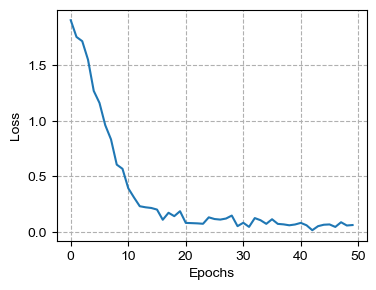

In [155]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

plt.figure(figsize=(4, 3))
plt.grid(linestyle="--")  # 设置背景网格线为虚线

plt.plot([i for i in range(len(loss_list))] ,loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.legend("best")
plt.savefig('mlp_loss.png', format='png', bbox_inches="tight",dpi=1080)
plt.show()

### GCN 进行分类任务

In [156]:
# 获取邻接矩阵
raw_data_cites = pd.read_csv('cora/cora.cites',sep = '\t',header = None)

# 将论文的编号转[0,2707]
a = list(raw_data.index)
b = list(raw_data[0])
c = zip(b,a)
map = dict(c)

# 创建一个规模和邻接矩阵一样大小的矩阵
matrix = np.zeros((num,num))
# 创建邻接矩阵
for i ,j in zip(raw_data_cites[0],raw_data_cites[1]):
    x = map[i] ; y = map[j]  #替换论文编号为[0,2707]
    matrix[x][y] = matrix[y][x] = 1 #有引用关系的样本点之间取1
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**GCN 消息传播**

* $\hat{A} = A + I, D_{ii} = \sum_j{\hat{A}_{ij}},  Z = D^{-\frac{1}{2}} * \hat{A} * D^{-\frac{1}{2}}$

**mean 消息传播**

* $\hat{A} = A + I, D_{ii} = \sum_j{\hat{A}_{ij}},  Z = D^{-1} * \hat{A} $

**sum 消息传播**

* $\hat{A} = A + I,  Z = \hat{A} $

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn.init as init

def message_GCN(adj):
    adj_hat = adj + np.eye(adj.shape[0]) # 为每个结点增加自环
    degree = np.array(adj_hat.sum(1)) # 为每个结点计算度
    degree = np.diag(np.power(degree, -0.5))
    return degree.dot(adj_hat).dot(degree)

def message_mean(adj):
    adj_hat = adj + np.eye(adj.shape[0]) # 为每个结点增加自环
    degree = np.array(adj_hat.sum(1)) # 为每个结点计算度
    degree = np.diag(np.power(degree, -1))
    return degree.dot(adj_hat)

def message_sum(adj):
    adj_hat = adj + np.eye(adj.shape[0]) # 为每个结点增加自环
    return adj_hat

class GraphConvolution(nn.Module):
    def __init__(self, input_size, output_size):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, adj, features):
        out = torch.mm(adj, features)
        out = self.linear(out)
        return out

class GCN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, n_class):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, hidden1)
        self.gcn2 = GraphConvolution(hidden1, hidden2)
        self.gcn3 = GraphConvolution(hidden2, n_class)
    
    def forward(self, adj, features):
        out = F.relu(self.gcn1(adj, features))
        out = F.relu(self.gcn2(adj, out))
        out = self.gcn3(adj, out)
        return out

learning_rate = 1e-3
epochs = 50
n_class = 7
message_list = ["GCN", "mean", "lap"]

# 不同消息传播机制
for message_name in message_list:
    if message_name == "GCN":
        adj = torch.tensor(message_GCN(matrix), dtype=torch.float32)
    elif message_name == "mean":
        adj = torch.tensor(message_mean(matrix), dtype=torch.float32)
    elif message_name == "sum":
        adj = torch.tensor(message_sum(matrix), dtype=torch.float32)
    
    G_model = GCN(features.shape[1], 128, 32, n_class)
    optimizer = torch.optim.Adam(G_model.parameters(), lr=learning_rate, weight_decay=5e-4)
    # 模型训练
    G_model.train()
    for epoch in range(epochs):
        G_model.zero_grad()
        logit = G_model(adj, features)
        loss = F.cross_entropy(logit[:1000], train_labels)
        # print (loss)
        loss.backward()
        optimizer.step()

    # 模型测试
    G_model.eval()
    logit = G_model(adj, features) 
    print (f"Message mechanism: {message_name}, Accuracy score is: {(logit[1000:].argmax(axis=1) == test_labels).sum() / test_labels.shape[0]}")

Message mechanism: GCN, Accuracy score is: 0.8372365236282349
Message mechanism: mean, Accuracy score is: 0.834894597530365
Message mechanism: lap, Accuracy score is: 0.8272833824157715


### 随机删除边

* 随机丢弃边，设置为 [0.1, 0.3, 0.5, 0.7, 0.9]

In [158]:
random_p = [0.1, 0.3, 0.5, 0.7, 0.9]

edge_list = [] # 记录边的两边节点信息
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if j >= i and matrix[i][j] == 1:
            edge_list.append([i, j])

def edge_remove(matrix, edge_list, p=0.1):
    remove_edge_index = np.random.choice([i for i in range(len(edge_list))], size=int(len(edge_list) * p), replace=False) # 不重复的删除边
    remove_edge_list = np.array(edge_list)[remove_edge_index]
    remove_matrix = matrix.copy()

    for edge in remove_edge_list:
        remove_matrix[edge[0]][edge[1]] = 0
        remove_matrix[edge[1]][edge[0]] = 0
    return remove_matrix

# remove_matrix = edge_remove(matrix, edge_list)
# (matrix == 1).sum()
# (remove_matrix == 1).sum()
learning_rate = 1e-3
epochs = 50
n_class = 7
message_list = ["GCN", "mean", "sum"]

accuracy_list = []

# 不同消息传播机制
for message_name in message_list:
    # 不同丢弃边比例对模型的影响
    for p in random_p:
        remove_matrix = edge_remove(matrix, edge_list, p=p)
        if message_name == "GCN":
            adj = torch.tensor(message_GCN(remove_matrix), dtype=torch.float32)
        elif message_name == "mean":
            adj = torch.tensor(message_mean(remove_matrix), dtype=torch.float32)
        elif message_name == "sum":
            adj = torch.tensor(message_sum(remove_matrix), dtype=torch.float32)
        
        # adj = torch.tensor(message_GCN(remove_matrix), dtype=torch.float32)

        G_model = GCN(features.shape[1], 128, 32, n_class)
        optimizer = torch.optim.Adam(G_model.parameters(), lr=learning_rate, weight_decay=5e-4)
        # 模型训练
        G_model.train()
        for epoch in range(epochs):
            G_model.zero_grad()
            logit = G_model(adj, features)
            loss = F.cross_entropy(logit[:1000], train_labels)
            # print (loss)
            loss.backward()
            optimizer.step()

        # 模型测试
        G_model.eval()
        logit = G_model(adj, features)
        accuracy_score = (logit[1000:].argmax(axis=1) == test_labels).sum() / test_labels.shape[0]

        accuracy_list.append(accuracy_score)
        print (f"Message mechanisim: {message_name}, Random remove ratio: {p}, Accuracy score is: {accuracy_score}")

Message mechanisim: GCN, Random remove ratio: 0.1, Accuracy score is: 0.8208431005477905
Message mechanisim: GCN, Random remove ratio: 0.3, Accuracy score is: 0.7950819730758667
Message mechanisim: GCN, Random remove ratio: 0.5, Accuracy score is: 0.7546838521957397
Message mechanisim: GCN, Random remove ratio: 0.7, Accuracy score is: 0.7201405167579651
Message mechanisim: GCN, Random remove ratio: 0.9, Accuracy score is: 0.6522248387336731
Message mechanisim: mean, Random remove ratio: 0.1, Accuracy score is: 0.8126463890075684
Message mechanisim: mean, Random remove ratio: 0.3, Accuracy score is: 0.7909836173057556
Message mechanisim: mean, Random remove ratio: 0.5, Accuracy score is: 0.7593677043914795
Message mechanisim: mean, Random remove ratio: 0.7, Accuracy score is: 0.7113583087921143
Message mechanisim: mean, Random remove ratio: 0.9, Accuracy score is: 0.6604215502738953
Message mechanisim: sum, Random remove ratio: 0.1, Accuracy score is: 0.7377049326896667
Message mechanis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


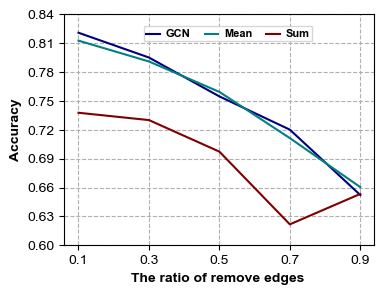

In [159]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# label在图示(legend)中显示。若为数学公式,则最好在字符串前后添加"$"符号
# color：b:blue、g:green、r:red、c:cyan、m:magenta、y:yellow、k:black、w:white、、、
# 线型：-  --   -.  :    ,
# marker：.  ,   o   v    <    *    +    1
plt.figure(figsize=(4, 3))
plt.grid(linestyle="--")  # 设置背景网格线为虚线

plt.plot(random_p, accuracy_list[0:5],color="Navy", label="GCN")
plt.plot(random_p, accuracy_list[5:10], color="Teal", label="Mean")
plt.plot(random_p, accuracy_list[10:15], color="Maroon",label="Sum")

plt.xlabel("The ratio of remove edges ", fontsize=10, fontweight='bold')
plt.ylabel("Accuracy", fontsize=10, fontweight='bold')
# plt.title("The impact of different message propagating and ratio of remove edges on accuracy", fontsize=8)

plt.legend(loc=0, ncol=3, borderaxespad = 0.,bbox_to_anchor=(0.8,0.95),fontsize=5)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.xticks(random_p)
plt.yticks([0.6 + 0.03*i for i in range(9)])
plt.setp(ltext, fontsize=8, fontweight='bold')  # 设置图例字体的大小和粗细

plt.savefig('remove_edge.png', format='png', bbox_inches="tight",dpi=1080)
plt.show()
